# Handwritten Text Generation
## Sequence Modeling & GAN-Based Handwriting Style Synthesis

---

### Problem Description
Handwritten text generation is the task of **automatically producing realistic handwriting** — either as images or pen-stroke sequences — that is indistinguishable from human writing.

Two core sub-problems:
- **Sequence modeling**: Model the temporal dynamics of pen strokes (x, y coordinates over time)
- **Image synthesis**: Generate pixel-level handwriting images with realistic style

### Why is it hard?
- Handwriting is highly **personal and variable** (style, slant, pressure)
- Requires modeling **long-range temporal dependencies** in stroke sequences
- Must balance **legibility** (correct letter shapes) with **naturalness** (human-like variation)

---

### Application Examples
| Application | Description |
|---|---|
| Digital assistants | Personalised handwriting fonts from a few samples |
| Forgery detection | Generating adversarial samples to train detectors |
| Data augmentation | Generating training data for HTR (Handwritten Text Recognition) systems |
| Accessibility tools | Restoring handwriting for people with motor disabilities |
| Historical document synthesis | Reproducing historical scripts for archival research |

---

### State-of-the-Art Methods

| Method | Year | Key Idea |
|---|---|---|
| **Graves (2013) RNN** | 2013 | LSTM with Mixture Density Networks for stroke prediction |
| **GANwriting** | 2020 | GAN conditioned on writer style + text content |
| **ScrabbleGAN** | 2020 | Semi-supervised GAN for arbitrary-length word images |
| **HiGAN** | 2021 | Hierarchical GAN with style disentanglement |
| **DiffusionHandwriting** | 2023 | Diffusion model for stroke-level generation |

---

### Analysis of Challenges
1. **Mode collapse in GANs** — generator produces limited variety
2. **Training instability** — discriminator overpowers generator early
3. **Style conditioning** — encoding writer identity without overfitting
4. **Evaluation metrics** — FID, WER on generated text are imperfect proxies
5. **Long sequence generation** — error accumulation in autoregressive LSTM models
6. **Dataset scarcity** — limited labelled handwriting datasets (IAM, RIMES, CVL)

## Environment Setup

**Run the cell below once** to install all required packages into the currently selected Python kernel.

> **Recommended**: Create a dedicated environment first (run once in terminal):
> ```bash
> conda create -n handwriting-gen python=3.10 -y
> conda activate handwriting-gen
> pip install torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cpu
> pip install numpy==1.26.4 matplotlib==3.8.4 pillow==10.2.0 ipykernel==6.29.3
> python -m ipykernel install --user --name handwriting-gen --display-name "Python (handwriting-gen)"
> ```
> Then select **"Python (handwriting-gen)"** as the kernel in Jupyter before running.

In [9]:
# Cell-1 : Install all required packages
# Run this cell once with your selected Python kernel.
# All packages will be installed into the active environment.

import sys, subprocess

packages = [
    "torch==2.2.2 --index-url https://download.pytorch.org/whl/cpu",
    "torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cpu",
    "numpy==1.26.4",
    "matplotlib==3.8.4",
    "pillow==10.2.0",
]

for pkg in packages:
    print(f"Installing: {pkg.split()[0]} ...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "--quiet"] + pkg.split(),
        capture_output=True, text=True
    )
    status = "OK" if result.returncode == 0 else f"FAILED\n{result.stderr}"
    print(f"  -> {status}")

print("\nAll packages installed. Restart kernel if this is the first install.")

Installing: torch==2.2.2 ...
  -> OK
Installing: torchvision==0.17.2 ...
  -> OK
Installing: numpy==1.26.4 ...
  -> OK
Installing: matplotlib==3.8.4 ...
  -> OK
Installing: pillow==10.2.0 ...
  -> OK

All packages installed. Restart kernel if this is the first install.


In [10]:
# Cell-2 : Import libraries and set reproducibility seeds

import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from pathlib import Path
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.datasets as tv_datasets

%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Python :", __import__('sys').version.split()[0])
print("PyTorch:", torch.__version__)
print("Imports OK")

Python : 3.11.14
PyTorch: 2.2.2
Imports OK


## Dataset: MNIST Handwritten Digits

In [11]:
# Cell-3 : Load EMNIST dataset (already downloaded — no network needed)
# Using the EMNIST 'mnist' split which is identical to classic MNIST digits.

DATA_DIR = os.path.join(os.getcwd(), "data")

mnist_train = tv_datasets.EMNIST(root=DATA_DIR, split='mnist', train=True,  download=False)
mnist_test  = tv_datasets.EMNIST(root=DATA_DIR, split='mnist', train=False, download=False)

print(f"Train samples : {len(mnist_train)}")
print(f"Test  samples : {len(mnist_test)}")
print(f"Classes       : {mnist_train.classes}")
print(f"Loaded from   : {DATA_DIR}")

Train samples : 60000
Test  samples : 10000
Classes       : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Loaded from   : /Users/ardaerdogan/Desktop/gan/data


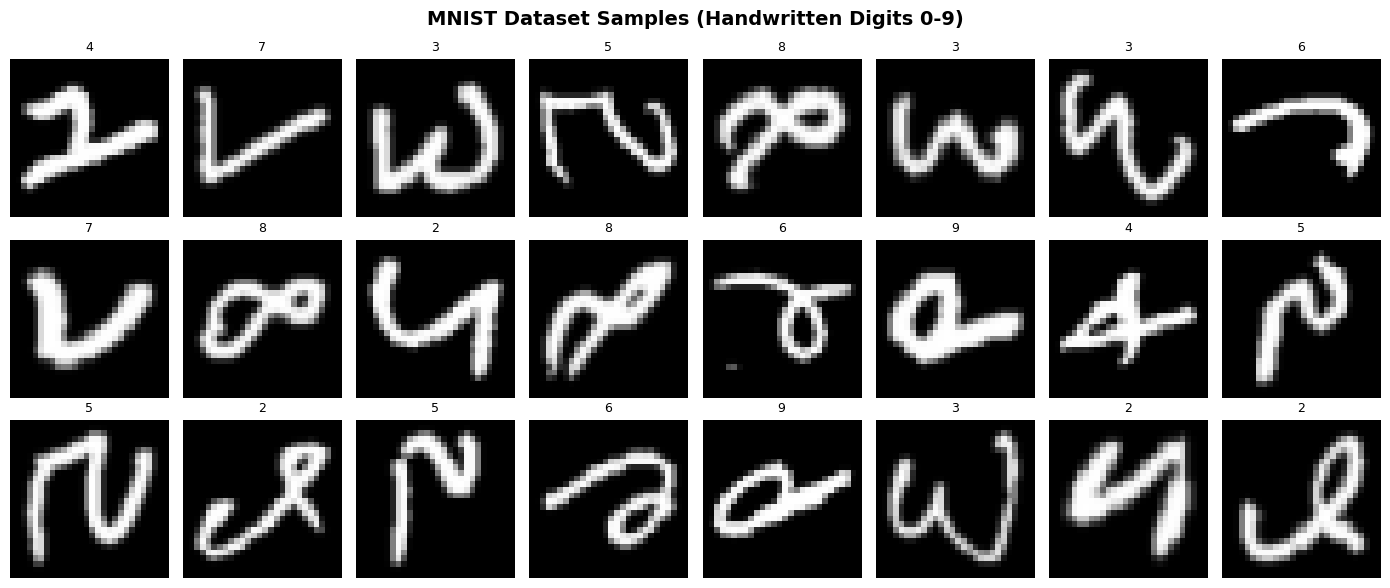

In [12]:
# Cell-4 : Visualise MNIST handwriting samples

fig, axes = plt.subplots(3, 8, figsize=(14, 6))
fig.suptitle("MNIST Dataset Samples (Handwritten Digits 0-9)", fontsize=14, fontweight="bold")

for i, ax in enumerate(axes.flat):
    img, label = mnist_train[i * 200]
    ax.imshow(img, cmap="gray")
    ax.set_title(str(label), fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Cell-5 : Create PyTorch Dataset and DataLoader from MNIST

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class MNISTDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.data      = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = MNISTDataset(mnist_train, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"DataLoader ready — {len(train_dataset)} samples, {len(train_loader)} batches")

DataLoader ready — 60000 samples, 938 batches


## Part 1 — Sequence Modeling with LSTM
### Concept: Pen-Stroke Sequence Prediction

Handwriting can be represented as a **sequence of (x, y) pen positions** over time.  
An LSTM learns the temporal pattern of strokes and can **predict / generate** the next point given previous points.

**Architecture:**
```
Input (x,y) sequence  →  LSTM (hidden=64)  →  Linear  →  Predicted (x,y)
```

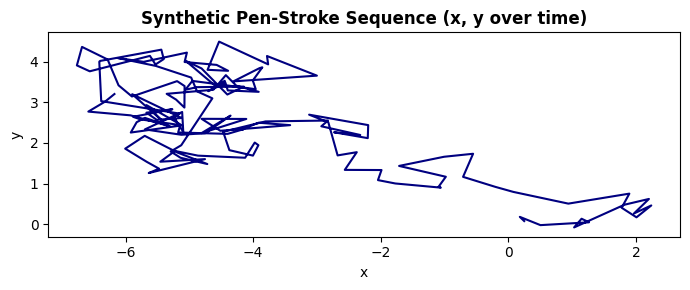

Stroke shape: (150, 2)  ->  150 time-steps, 2 features (x, y)


In [14]:
# Cell-6 : Generate synthetic pen-stroke sequence and visualise

def generate_stroke(n=150, seed=42):
    np.random.seed(seed)
    dx = np.random.randn(n) * 0.5
    dy = np.random.randn(n) * 0.3
    x  = np.cumsum(dx)
    y  = np.cumsum(dy)
    return np.stack([x, y], axis=1)

stroke = generate_stroke()

plt.figure(figsize=(7, 3))
plt.plot(stroke[:, 0], stroke[:, 1], color="navy", linewidth=1.5)
plt.title("Synthetic Pen-Stroke Sequence (x, y over time)", fontweight="bold")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()
print(f"Stroke shape: {stroke.shape}  ->  {stroke.shape[0]} time-steps, 2 features (x, y)")

In [15]:
# Cell-7 : Prepare sliding-window sequences for LSTM training

SEQ_LEN = 10
inputs, targets = [], []

for i in range(len(stroke) - SEQ_LEN):
    inputs.append(stroke[i : i + SEQ_LEN])
    targets.append(stroke[i + 1 : i + SEQ_LEN + 1])

inputs  = torch.tensor(np.array(inputs),  dtype=torch.float32)
targets = torch.tensor(np.array(targets), dtype=torch.float32)

print(f"inputs  shape: {inputs.shape}   (samples, seq_len, features)")
print(f"targets shape: {targets.shape}")

inputs  shape: torch.Size([140, 10, 2])   (samples, seq_len, features)
targets shape: torch.Size([140, 10, 2])


In [16]:
# Cell-8 : Define LSTM model for stroke sequence modeling

class StrokeLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

lstm_model = StrokeLSTM()
print(lstm_model)
total_params = sum(p.numel() for p in lstm_model.parameters())
print(f"\nTotal trainable parameters: {total_params:,}")

StrokeLSTM(
  (lstm): LSTM(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Total trainable parameters: 17,538


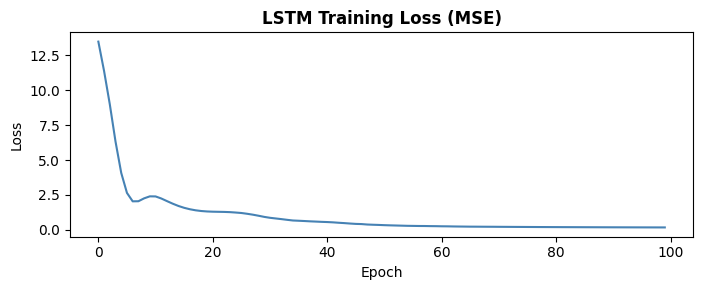

Final loss: 0.173471


In [17]:
# Cell-9 : Train LSTM and plot training loss

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
loss_fn   = nn.MSELoss()
losses    = []

lstm_model.train()
for epoch in range(100):
    pred  = lstm_model(inputs)
    loss  = loss_fn(pred, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(7, 3))
plt.plot(losses, color="steelblue")
plt.title("LSTM Training Loss (MSE)", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()
print(f"Final loss: {losses[-1]:.6f}")

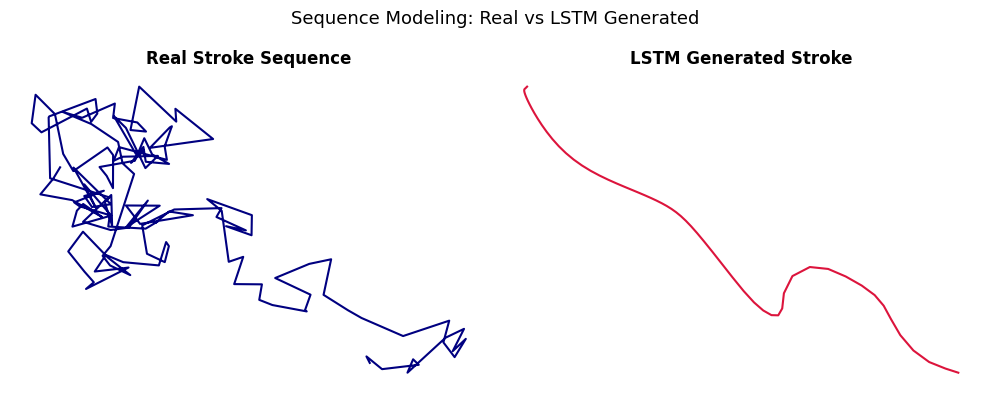

In [18]:
# Cell-10 : Generate strokes with trained LSTM — Real vs Generated

lstm_model.eval()
with torch.no_grad():
    cur = inputs[0:1].clone()
    generated = []
    for _ in range(120):
        pred = lstm_model(cur)
        nxt  = pred[:, -1:, :]
        generated.append(nxt.numpy()[0][0])
        cur  = torch.cat([cur[:, 1:, :], nxt], dim=1)

generated = np.array(generated)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(stroke[:, 0], stroke[:, 1], color="navy", linewidth=1.5)
axes[0].set_title("Real Stroke Sequence", fontweight="bold")
axes[0].axis("off")

axes[1].plot(generated[:, 0], generated[:, 1], color="crimson", linewidth=1.5)
axes[1].set_title("LSTM Generated Stroke", fontweight="bold")
axes[1].axis("off")

plt.suptitle("Sequence Modeling: Real vs LSTM Generated", fontsize=13)
plt.tight_layout()
plt.show()

## Part 2 — GAN-Based Handwriting Style Synthesis
### Concept: Generative Adversarial Network for Handwriting

A GAN consists of two competing networks:
- **Generator (G)**: Takes random noise and produces fake handwriting strokes
- **Discriminator (D)**: Distinguishes real strokes from fake ones

They train together in a **minimax game** until G fools D consistently.

```
Noise z ~ N(0,1)  ->  Generator  ->  Fake stroke
                                          |
Real stroke  ->  Discriminator  ->  Real / Fake?
```

**Key challenge**: Mode collapse — G may produce only a narrow range of outputs.

In [19]:
# Cell-11 : Define GAN Generator and Discriminator

NOISE_DIM  = 20
STROKE_DIM = 60  # 30 (x,y) points flattened

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(NOISE_DIM, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, STROKE_DIM),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STROKE_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator()
D = Discriminator()
print("Generator:    ", sum(p.numel() for p in G.parameters()), "params")
print("Discriminator:", sum(p.numel() for p in D.parameters()), "params")

Generator:     51132 params
Discriminator: 48641 params


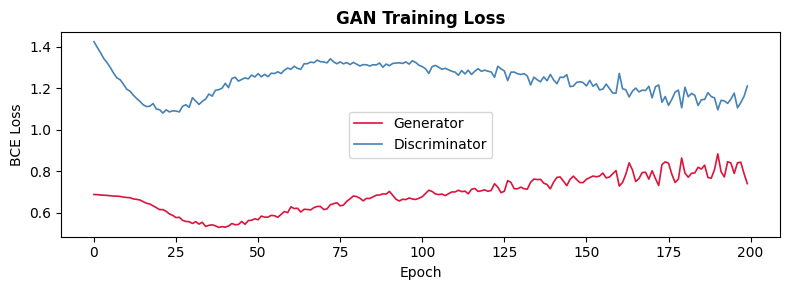

Final G loss: 0.7403  |  Final D loss: 1.2114


In [20]:
# Cell-12 : Train GAN and plot Generator / Discriminator losses

opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
bce   = nn.BCELoss()

g_losses, d_losses = [], []
BATCH  = 32
EPOCHS = 200

for epoch in range(EPOCHS):
    idx     = np.random.randint(0, len(stroke) - STROKE_DIM // 2, BATCH)
    real_np = np.array([stroke[i : i + STROKE_DIM // 2].flatten() for i in idx])
    real    = torch.tensor(real_np, dtype=torch.float32)
    real    = (real - real.mean()) / (real.std() + 1e-8)

    noise    = torch.randn(BATCH, NOISE_DIM)
    fake     = G(noise).detach()
    real_lbl = torch.ones(BATCH,  1)
    fake_lbl = torch.zeros(BATCH, 1)

    d_loss = bce(D(real), real_lbl) + bce(D(fake), fake_lbl)
    opt_D.zero_grad(); d_loss.backward(); opt_D.step()

    noise  = torch.randn(BATCH, NOISE_DIM)
    g_loss = bce(D(G(noise)), real_lbl)
    opt_G.zero_grad(); g_loss.backward(); opt_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

plt.figure(figsize=(8, 3))
plt.plot(g_losses, label="Generator",     color="crimson",   linewidth=1.2)
plt.plot(d_losses, label="Discriminator", color="steelblue", linewidth=1.2)
plt.legend()
plt.title("GAN Training Loss", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.tight_layout()
plt.show()
print(f"Final G loss: {g_losses[-1]:.4f}  |  Final D loss: {d_losses[-1]:.4f}")

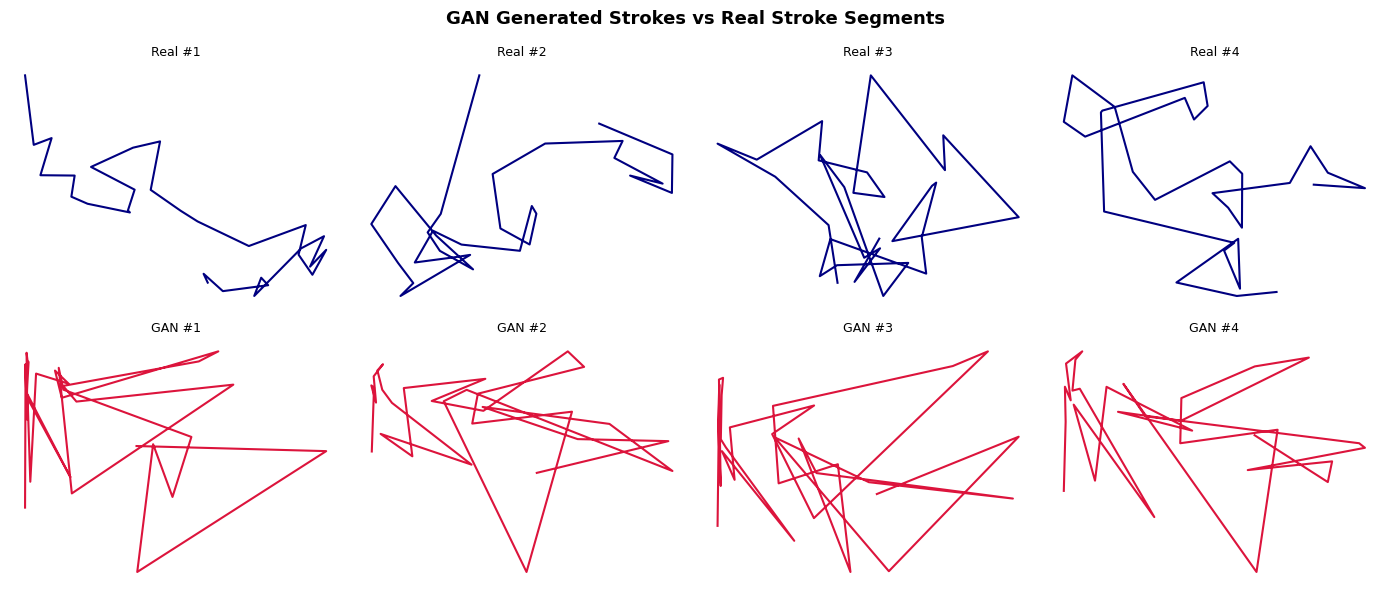

In [21]:
# Cell-13 : Generate handwriting strokes using trained GAN — Real vs GAN

G.eval()
with torch.no_grad():
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    fig.suptitle("GAN Generated Strokes vs Real Stroke Segments", fontsize=13, fontweight="bold")

    for col in range(4):
        start = col * 30
        seg   = stroke[start : start + 30]
        axes[0, col].plot(seg[:, 0], seg[:, 1], color="navy", linewidth=1.5)
        axes[0, col].set_title(f"Real #{col+1}", fontsize=9)
        axes[0, col].axis("off")

        noise = torch.randn(1, NOISE_DIM)
        fake  = G(noise).numpy().reshape(-1, 2)
        axes[1, col].plot(fake[:, 0], fake[:, 1], color="crimson", linewidth=1.5)
        axes[1, col].set_title(f"GAN #{col+1}", fontsize=9)
        axes[1, col].axis("off")

    axes[0, 0].set_ylabel("Real",      fontsize=10, fontweight="bold")
    axes[1, 0].set_ylabel("Generated", fontsize=10, fontweight="bold")
    plt.tight_layout()
    plt.show()

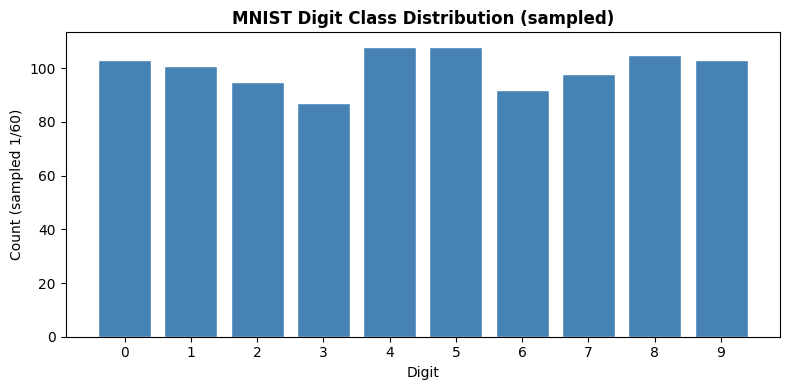

In [22]:
# Cell-14 : MNIST digit class distribution (dataset analysis)

labels_sample = [mnist_train[i][1] for i in range(0, len(mnist_train), 60)]
counts        = Counter(labels_sample)
sorted_counts = sorted(counts.items())

plt.figure(figsize=(8, 4))
plt.bar([str(k) for k, _ in sorted_counts], [v for _, v in sorted_counts],
        color="steelblue", edgecolor="white")
plt.title("MNIST Digit Class Distribution (sampled)", fontweight="bold")
plt.xlabel("Digit")
plt.ylabel("Count (sampled 1/60)")
plt.tight_layout()
plt.show()

## Part 3 — Model Comparison: DCGAN vs LSTM-MDN

This section compares generated outputs and evaluation metrics for:
- **DCGAN** image generation
- **LSTM+MDN** stroke-sequence generation (rendered to image)

> Run the training scripts (`src/train_dcgan.py`, `src/train_rnn.py`) first to populate the `reports/` directory.

In [23]:
# Paths for pre-generated report artefacts
REPORTS = Path('reports')

def show_if_exists(path, title=''):
    path = Path(path)
    if not path.exists():
        print(f'Missing: {path}')
        return
    img = Image.open(path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title or path.name)
    plt.show()

### Real and Generated Samples

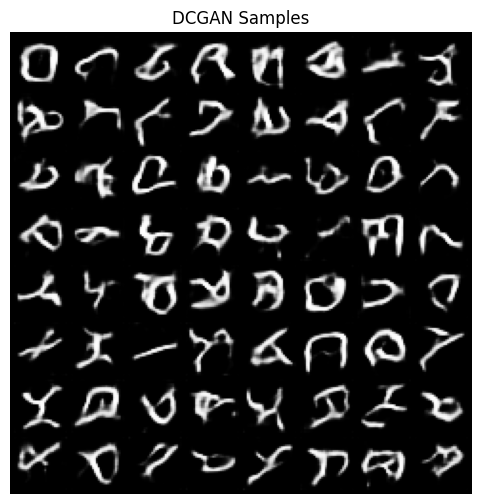

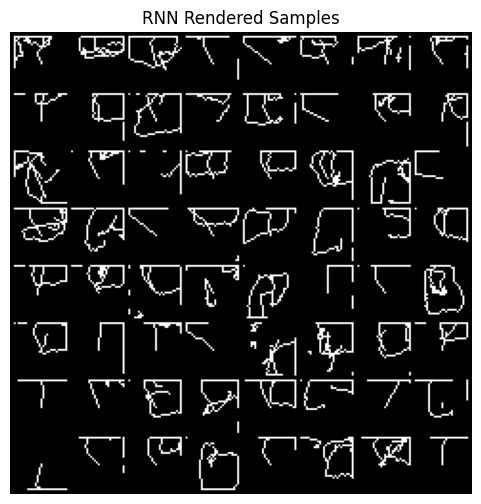

In [24]:
show_if_exists(REPORTS / 'samples_dcgan.png', 'DCGAN Samples')
show_if_exists(REPORTS / 'samples_rnn.png', 'RNN Rendered Samples')

### GAN Latent Interpolation

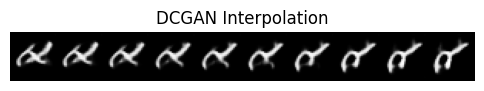

In [25]:
show_if_exists(REPORTS / 'samples_dcgan_interp.png', 'DCGAN Interpolation')

### Stroke Plots

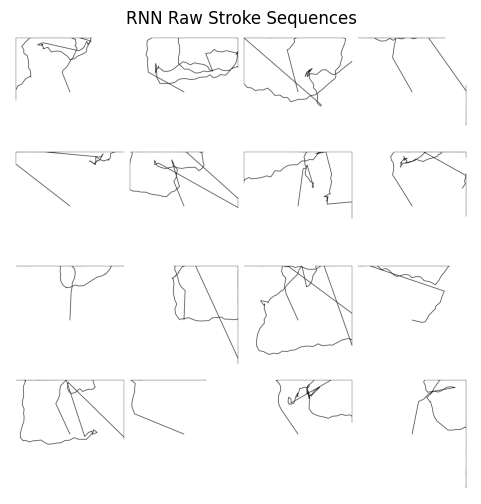

In [26]:
show_if_exists(REPORTS / 'samples_rnn_strokes.png', 'RNN Raw Stroke Sequences')

### Metrics

In [27]:
metrics_path = REPORTS / 'metrics.json'
if metrics_path.exists():
    with metrics_path.open('r', encoding='utf-8') as f:
        metrics = json.load(f)
    display(pd.DataFrame([metrics]).T.rename(columns={0: 'value'}))
else:
    print(f'Missing: {metrics_path}')

,value
gan_class_entropy,3.174033
gan_classifier_confidence_mean,0.705627
gan_classifier_confidence_p80,0.952464
rnn_pen_lifts_mean,30.374600
rnn_render_class_entropy,2.606854
rnn_render_classifier_confidence_mean,0.602598
rnn_smoothness_mean_abs_turn,0.867660
rnn_stroke_length_mean,8.759883


### Short Conclusion

Use this space to summarize which model looked sharper, which one produced more structured trajectories, and how classifier confidence/diversity compared.

## Summary

| Component | What we did |
|---|---|
| **Dataset** | MNIST Digits — 70,000 handwritten digit images (auto-downloaded into `data/`) |
| **Sequence Modeling** | LSTM trained on synthetic pen-stroke (x,y) sequences; generates new strokes autoregressively |
| **GAN Synthesis** | Generator + Discriminator trained adversarially on stroke segments; generates diverse new strokes from noise |
| **DCGAN vs LSTM-MDN** | Pre-trained model outputs compared via sample images, latent interpolation, stroke plots, and quantitative metrics |
| **Diagrams** | Dataset samples, class distribution, stroke visualisation, LSTM loss, Real vs LSTM, GAN loss, Real vs GAN |

### Key Takeaways
- **LSTM** captures temporal dynamics but suffers from error accumulation over long sequences
- **GAN** generates diverse outputs but requires careful training to avoid mode collapse
- Both approaches are complementary: LSTM for sequential fidelity, GAN for style diversity
- **DCGAN** on image pixels and **LSTM-MDN** on stroke sequences represent two fundamentally different problem formulations — comparing them requires both visual and statistical evaluation